# AI & Biomedical : Big data in bioimagery


                        sarah.laroui@inria.fr
                        07/10/2019

A binomial report must be sent by email no later than 14/10.

Submitted by:

## Introduction: 

In this project a high content microscopy based screening focused on the effects of endocrinedisruptors on prostatic cancer cells metabolism. Mitochondria have a wide variety of forms due to different types of stress (metabolic, energy, etc.) that the cell and its mitochondria undergo.

In this TP, the goal is to develop a tool to detect and classify the different mitochondrial network morphology types from microscopy acquired images.

In [33]:
# Useful functions and imports

import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import regionprops, label

import os
import os.path
import sys
import glob as glb
from skimage import io, img_as_uint
from skimage.io import imsave

From a computer point of view, an image is a matrix where each box represents
a pixel. These boxes contain either a single value if it is an image in gray levels, three values corresponding to the three primary colors if it is an image
in colors. Mixing these intensities will give a pixel-specific color.


  - Import and display images with pyplot. 

In [34]:
## Parameter initialization

image_ext = 'tif'

Path = 'Data/'#'Enter the path to the folder containing the train and test folders'

## Creation of the "Mask" folder, this folder will contain the binary masks of the images

if not os.path.exists(Path + "Mask/"):
    os.mkdir(Path + "Mask/")

## Reading images

##### Train

path_images_TrainingSet = Path + 'Train/'
All_images_TrainingSet = glb.glob(os.path.join(os.path.expanduser(path_images_TrainingSet), '*.' + image_ext))

##### Test

path_images_TestSet = Path + 'Test/'
All_images_TestSet = glb.glob(os.path.join(os.path.expanduser(path_images_TestSet), '*.' + image_ext))


In [35]:
All_images_TestSet

['Data/Test\\FilTest1.tif',
 'Data/Test\\FragTest1.tif',
 'Data/Test\\normalTest1.tif']

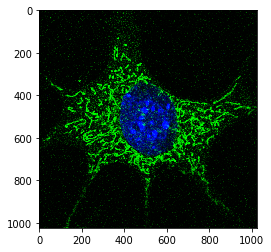

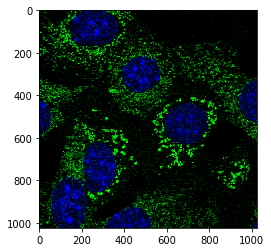

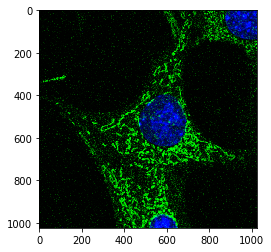

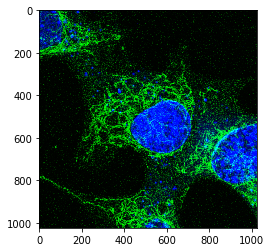

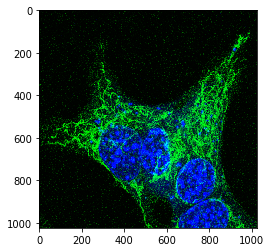

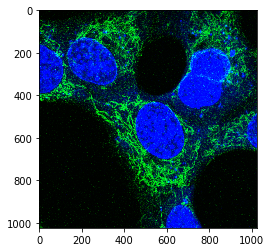

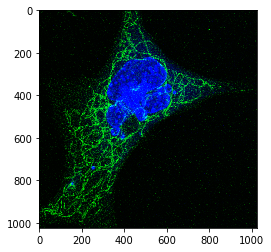

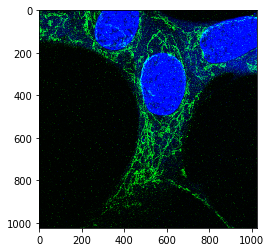

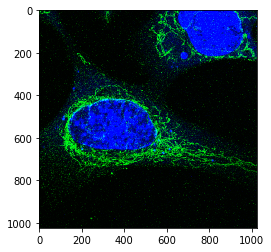

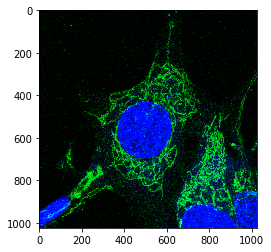

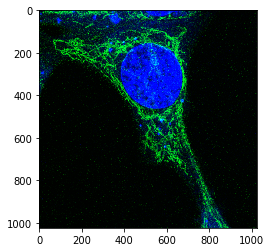

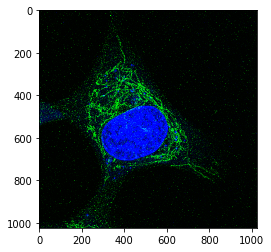

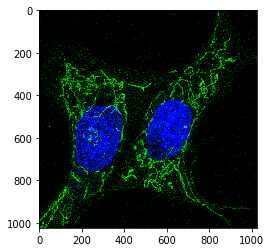

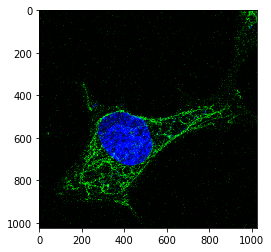

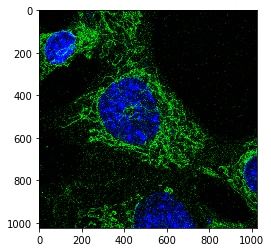

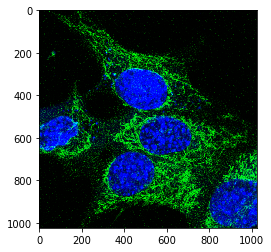

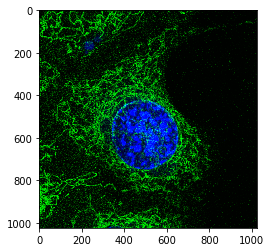

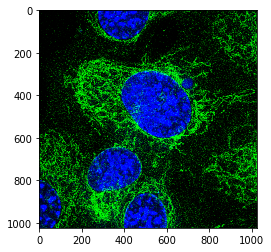

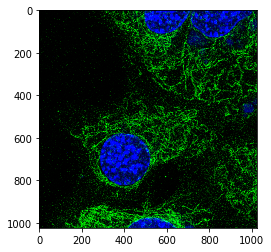

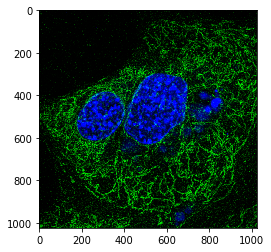

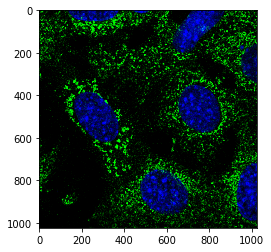

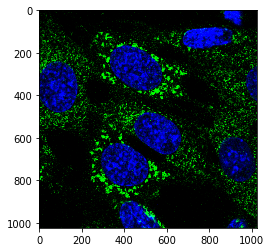

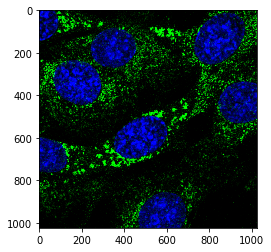

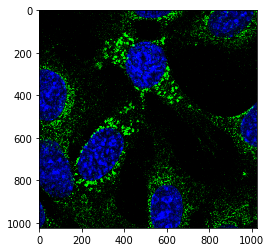

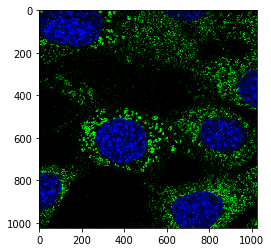

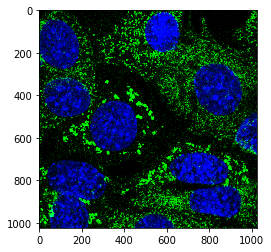

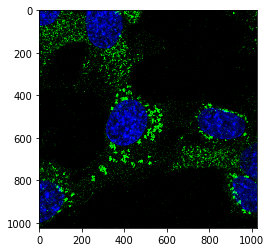

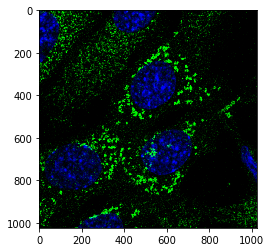

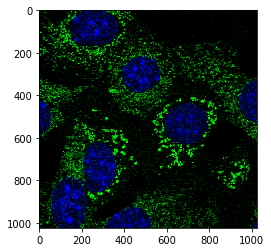

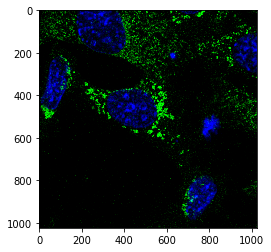

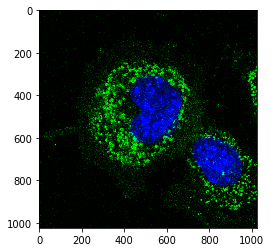

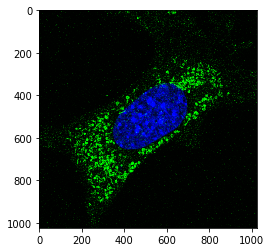

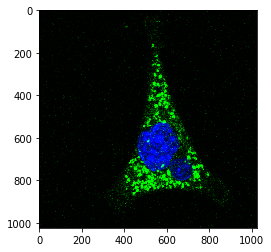

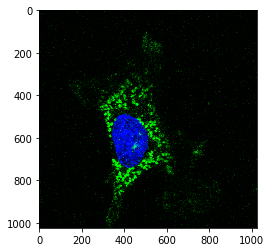

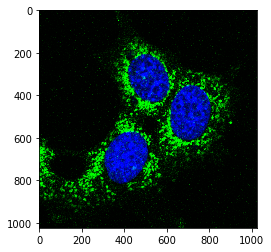

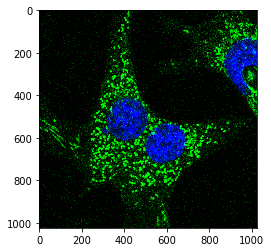

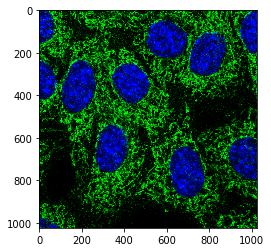

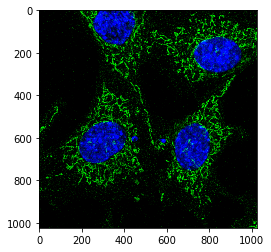

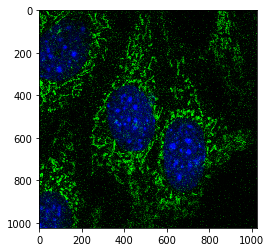

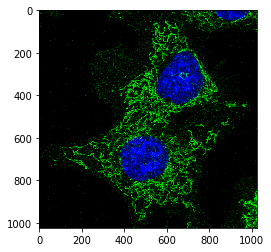

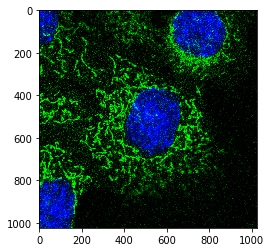

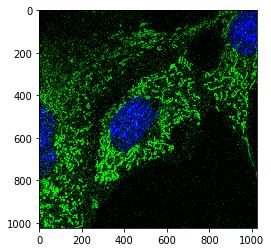

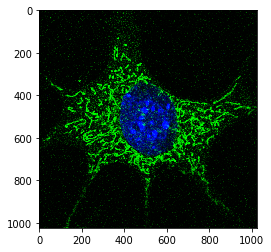

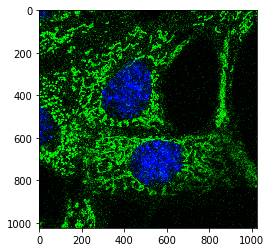

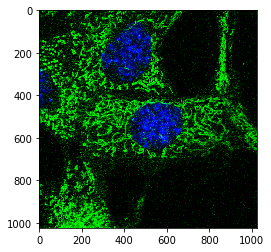

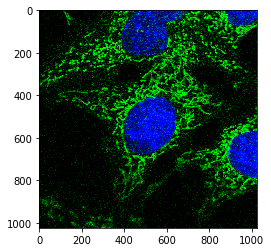

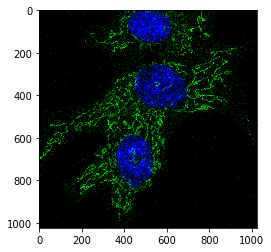

In [36]:
#We display all images, test and train
for i in All_images_TestSet:
    img = plt.imread(i)
    plt.imshow(img)
    plt.show()
    
for i in All_images_TrainingSet:
    img = plt.imread(i)
    plt.imshow(img)
    plt.show()

Function allowing the detection of the objects of the image.

In this part:
- What represents the parameter s?

The parameter s is responsible for the color channel, where R=0, G=1, B=2, so by choosing 1, we will work on the blue part and try to eliminate it.
- Try several threshold values on the intensity of the image, until you find the most suitable.

We tried to input the threshold on intensity by hand but decided that the best approach is to use a ready function "threshold_otsu" as suggested by the lecturer with the approximate value of 90
- Explain the noise in the image.

The noise in an image can appear due to multiple reasons, for example: the imperfection of the measuring device - the microscope, the size of the measured object - nanometers in case of biomedical images, the fuzzyness created by even a smallest movement.
- Determine a second threshold on the size of the connected component which are not to be taken into account.

After a few attempts with differnt sizes of objects that should be ignored we conclude that there is a visible improvement after reducing the value below 128 and setting it on ThreshOnObjSize = 8
- Complete the input of the function remove_small_objects.

The function takes two arguments - the image and the size of the objects to be ignored
- Explain in a few lines the role of the mathematical morphology operations used and determine the radius of the structural element.

Mathematical morphology operations such as normalization, thresholding, binarization and object handling help to perform the necessary steps to extract useful information from biomedical images. Those steps can be also used in other areas of image processsing.

Since the object is not always round and varies between images, the radius could fluctuate around 100 pixels. Knowing the real size of the tissue at the picture we can easily translate it to nm.






In [37]:
def normalize(img):
  '''
  Normalize the exposure of an image.
  @args:
    {numpy.ndarray} img: an array of image pixels with shape:
      (height, width)
  @returns:
    {numpy.ndarray} an image with shape of `img` wherein
      all values are normalized such that the min=0 and max=255
  '''
  _min = img.min()
  _max = img.max()
  return img - _min * 255 / (_max - _min)

In [38]:
def Objectdetection(img):
    
    s=1
    img = (img[:, :, s]) 

    IN = normalize(img)

    from skimage import filters

    ThreshOnIntensity = filters.threshold_otsu(IN) #To complete
    
    BinaryImg = IN > ThreshOnIntensity

    from skimage.morphology import remove_small_objects

    ThreshOnObjSize = 8 #To complete

    final = 1 * remove_small_objects(BinaryImg, ThreshOnObjSize) #To complete 
    
    from skimage import morphology
    from scipy import ndimage as nd
    
    
    #morphology.disk(radius) --> Generates a flat, disk-shaped structuring element.

    BinaryImg_clean = nd.binary_closing(final, morphology.disk(1))
    BinaryImg_clean = nd.binary_opening(BinaryImg_clean, morphology.disk(1))
   
    return img, BinaryImg_clean

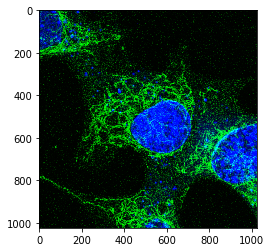

In [39]:
    img = plt.imread(All_images_TrainingSet[0])
    plt.imshow(img)
    plt.show()

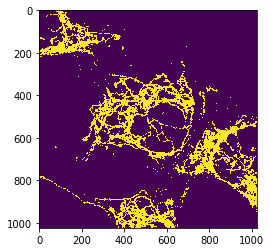

In [40]:
img2, binx = Objectdetection(img)
plt.imshow(binx)
plt.show()

Function allowing the calculation of objects features.

In this part:

- Explain the three parameters (areas, circularity, Length_weighted)

Areas: is the size of each object

Circularity: is how close to a perfect circle each object is

Length_weighted: is how far from each other the compared objects are

- Do you thing these parameters are adapted to discriminate the different types of networks? (Detail your answer)

In theory the more different characteristics of an object we can observe the better. From a short study we can see that the detectable objects are of similar shape, size and structure, but since it's real, noisy and imperfect data, we cannot rely on a hard classification limited to the characteristic that works the best. Since we assume that we have to create a general model for different types of networks, even the less significant features for now may prove invaluable with different input data.



In [41]:
def FeaturesOfObjects(labels, img):

    from skimage import morphology
    from scipy import ndimage as nd

    areas = [r.area for r in regionprops(labels, coordinates='xy')]
    centroids = [r.centroid for r in regionprops(labels, coordinates='xy')]
    perimeters = [r.perimeter for r in regionprops(labels, coordinates='xy')]
    orientations = [r.orientation for r in regionprops(labels, coordinates='xy')]

    coord = np.array([[int(r.centroid[0]), int(r.centroid[1])] for r in regionprops(labels)])
    coord = coord.reshape(2, len(coord))

    Circularity = [((r.area)/((r.perimeter)**2)) for r in regionprops(labels, coordinates='xy')]

    squelette = morphology.skeletonize(labels>0)
    dist_on_skel = nd.distance_transform_edt(labels>0)   # to the background for pixels of the skeleton
    Length_weighted = dist_on_skel * squelette
    Length_weighted_List = [np.sum(Length_weighted[(squelette*labels)==l]) for l in np.unique(labels)[1:]]
    
    return areas, centroids, perimeters, orientations, coord, Circularity, Length_weighted_List

In [42]:
#Feature Lists
AreasListToTrain = []
CircularityListToTrain = []
Length_weightedListToTrain = []

#Reading images and parameters extraction
for image in All_images_TrainingSet:
        
    basename = os.path.basename(image)
    img = io.imread(image)

    img, BinaryImg_clean = Objectdetection(img)

    labels = label(BinaryImg_clean)
    
    #if not os.path.exists(Path + "Mask/Train/"):
    #    os.mkdir(Path + "Mask/Train/")
    #imsave(Path + "Mask/Train/" + basename, img_as_uint(labels))
    areas, centroids, perimeters, orientations, coord, Circularity, Length_weighted = FeaturesOfObjects(labels, img)

    AreasListToTrain += areas
    CircularityListToTrain += Circularity
    Length_weightedListToTrain += Length_weighted


## Simple transformations 

The goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values. Every dataset does not require normalization. It is required only when features have different ranges.

In [43]:
#Feature normalization

MinArea = np.min(AreasListToTrain)
MaxArea = np.max(AreasListToTrain)
AreasListToTrain = (AreasListToTrain-MinArea)/(MaxArea - MinArea)

MinLength = np.min(Length_weightedListToTrain)
MaxLength = np.max(Length_weightedListToTrain)
Length_weightedListToTrain = (Length_weightedListToTrain-MinLength)/(MaxLength - MinLength)


## k-means clustering

k-means clustering is a method of vector quantization, originally from signal processing, that is popular for cluster analysis in data mining. k-means clustering aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster.

In this part:
- How many cluster you need? Precise this number by completing the variable "nb_clusters"

The mitochondrial network has 3 different states namely A) Aggregates, B) Tubular/Filamentous C) Hyper-filamentous. We want to separate the networks into these 3 different states. Hence the number of clusters needed is 3.

In [49]:
#Training instances to cluster

nb_clusters = 3 #To complete

Features = np.hstack((np.array(AreasListToTrain), np.array(Length_weightedListToTrain), np.array(CircularityListToTrain))).ravel()
X = Features.reshape(3, len(AreasListToTrain)).T 

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=nb_clusters, random_state=2).fit(X)

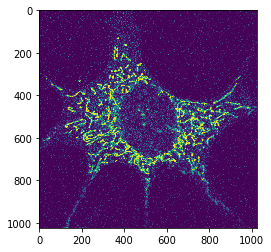

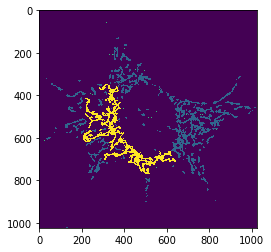

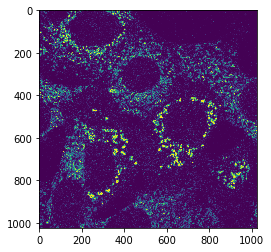

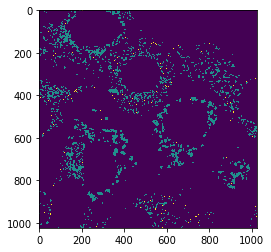

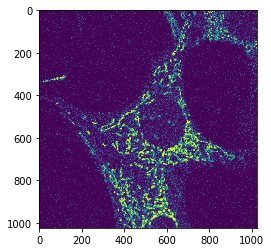

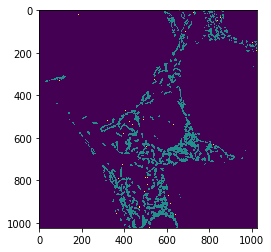

In [57]:
#Image Test detection, feature extraction and cluster prediction

for image in All_images_TestSet:
    basename = os.path.basename(image)
    
    img = io.imread(image)
    
    img, BinaryImg_clean = Objectdetection(img)
    
    plt.imshow(img)
    plt.show()

    from skimage.measure import regionprops, label
    labels = label(BinaryImg_clean)

    areas, centroids, perimeters, orientations, coord, Circularity, Length_weighted = FeaturesOfObjects(labels, img)

    areas = (areas - MinArea) / (MaxArea - MinArea)
    Length_weighted = (Length_weighted - MinLength) / (MaxLength - MinLength)
    Features = np.hstack((areas, Length_weighted, Circularity)).ravel()

    Xtest = Features.reshape(3, len(areas)).T

    Predictions = kmeans.predict(Xtest)

    ImageObjectsLabelizedByClass = 1*(BinaryImg_clean.copy())
    for l in np.unique(labels)[1:]:
        ImageObjectsLabelizedByClass[labels == l] = Predictions[l-1]+1
        
    plt.imshow(ImageObjectsLabelizedByClass)
    plt.show()
            



In this part:

- For each images to be tested, show the following images:
    - After detection and cleaning.
    - After classification: image labeled according to the belonging of the objects to the different clusters.
- Describe the characteristics of classes according to the features used.

Aggregates:
Characterized by circular shapes, big density and small distance between the entities

Tubular-filamentous:
Characterized by thick and short vein shapes, big density and small distance between the entities

Hyper-filamentous:
Characterized by long and thin vein shapes, smaller density and bigger distance between the entities

- Which step can be modified to improve the classification?

To improve the classification as discussed before we could include more features but also modify the thresholds as there might be a slightly better value for a set.
- What features can be added to improve classification?

It's difficult to discuss the usefulness of the features without necessary knowledge about the biology-based knowledge but it seems a notion of density or primitive shape could be taken from the data so that the classification is even more precise.

In [46]:
All_images_TestSet

['Data/Test\\FilTest1.tif',
 'Data/Test\\FragTest1.tif',
 'Data/Test\\normalTest1.tif']